# Identified protein of interest:
HSPA5 – heat shock protein family A (Hsp70) member 5
* https://www.ncbi.nlm.nih.gov/datasets/gene/3309/#transcripts-and-proteins

The UNIPROT ID of which is:
* NP_005338.1

In [ ]:
from Bio import Entrez, SeqIO
from io import StringIO
import pandas as pd
import re
from copy import copy
from Bio.Blast import NCBIWWW, NCBIXML

In [ ]:
human_prot_sequence_id = "NM_005347.5"
blast_target_organism = "Komagataella pastoris"
Entrez.email = "326povilas@gmail.com"

We also fetch the protein sequence

In [ ]:
def print_record(record):
    """Prints the ID, description, length, and sequence of a record."""
    print(f"ID: {record.id}")
    print(f"Description: {record.description}")
    print(f"Length: {len(record.seq)} nucleotides")
    print(f"Sequence:\n{record.seq}\n")

In [ ]:
handle = Entrez.efetch(db="protein", id="NP_005338.1", rettype="fasta", retmode="text")
HSP5_aa = SeqIO.read(handle, "fasta")
handle.close()

print_record(HSP5_aa)

we then blast this protein sequence to find homolog.

In [ ]:
result_handle = NCBIWWW.qblast("blastp", "nr", HSP5_aa.seq, entrez_query=f"{blast_target_organism}[Organism]")

blast_records = NCBIXML.parse(result_handle)
blast_record = next(blast_records)
result_handle.close()

In [ ]:

def extract_blast_records(blast_record):
    results = dict()
    for i, alignment in enumerate(blast_record.alignments):
        for hsp in alignment.hsps:
            source, id, text = alignment.title.split('|')[:3]

            # Extract organism name from text using regex
            organism = re.search(r'\[(.*?)\]', text).group(1)
            text = text.split('[')[0]

            results[i] = {
                'Source': source.strip(),
                "ID": id.strip(),
                "Text": text.strip(),
                "Organism": organism.strip(),
                "Score": hsp.score,
                "Identity": f"{hsp.identities}/{hsp.align_length} ({hsp.identities/hsp.align_length*100:.1f}%)",
                "Alignment Length": hsp.align_length,
                "Sequence": str(hsp.sbjct),
            }
     
            break

    return pd.DataFrame.from_dict(results, orient='index')


results = extract_blast_records(blast_record)
results

In [ ]:
from Bio import UniProt
resp = UniProt.search("XP_002491027.1")

In [ ]:
def unpack_uniprot_response(resp):
    resp = copy(resp)
    """Unpack UniProt response into a list of dictionaries."""

    try:
        record = resp[0] 

        print(record)
        record_dict = {
            'entryType': record.get('entryType'),
            'primaryAccession': record.get('primaryAccession'),
            'firstPublicDate': record['entryAudit'].get('firstPublicDate'),
            'lastAnnotationUpdateDate': record['entryAudit'].get('lastAnnotationUpdateDate'),

        }
        return record_dict
    except IndexError:
        print("No records found in the response.")
        return {}

def get_uniprot_id(ncbi_id):

    resp = UniProt.search(ncbi_id)
    record = unpack_uniprot_response(resp)
    uniprot_id = record.get('primaryAccession')

    return uniprot_id


results['UniProt_ID'] = results['ID'].apply(get_uniprot_id)

In [ ]:
human_prot_id = get_uniprot_id(human_prot_sequence_id)
print(f"UniProt ID for {human_prot_sequence_id}: {human_prot_id}")

In [ ]:
cols = results.columns.tolist()
cols.remove('UniProt_ID')
cols.insert(0, 'UniProt_ID')
results = results[cols]

results.dropna(subset=['UniProt_ID'], inplace=True)
results.to_csv(f'data/{human_prot_id}_to_blasted_pichia.csv', index=False)
results

# Inline pymol

In [1]:
import time
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import pymol
from pymol import cmd
import pandas as pd

In [ ]:
human_prot = human_prot_id if 'human_prot_id' in locals() else "P11021"

results = pd.read_csv(f'data/{human_prot}_to_blasted_pichia.csv')

pichia_proteins = list(results['UniProt_ID'])

In [3]:
pymol.finish_launching()
time.sleep(5)

In [4]:
cmd.do(f"fetchAF2 {human_prot}")
cmd.color("green", human_prot)

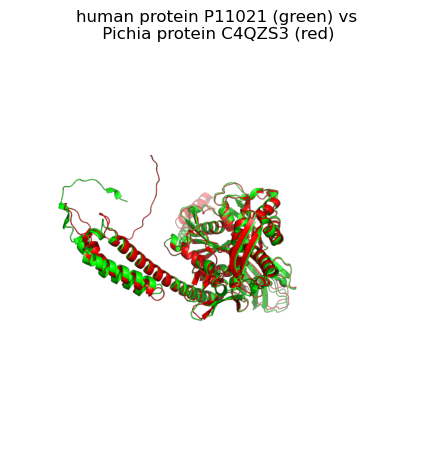

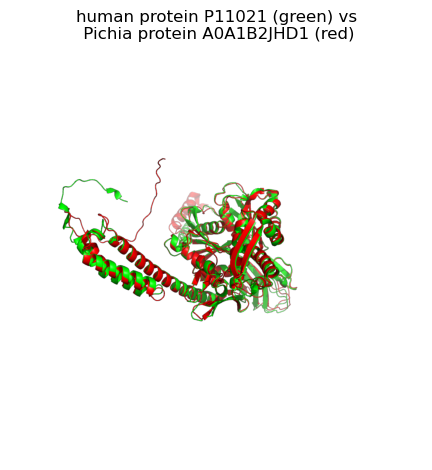

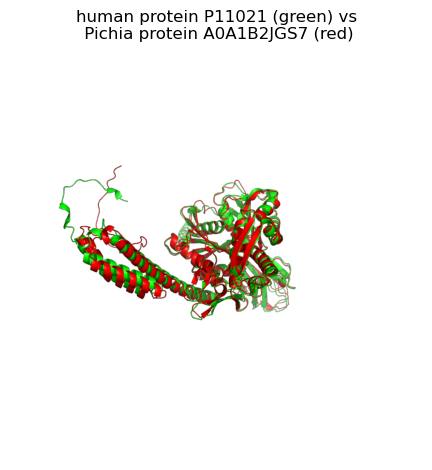

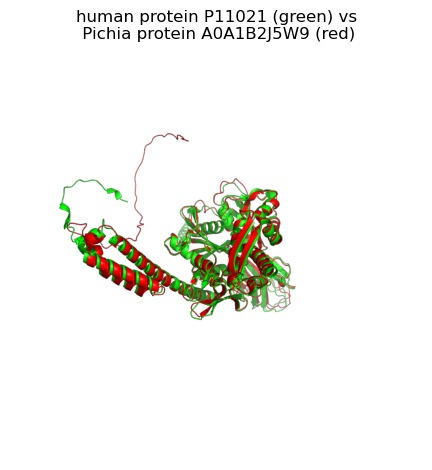

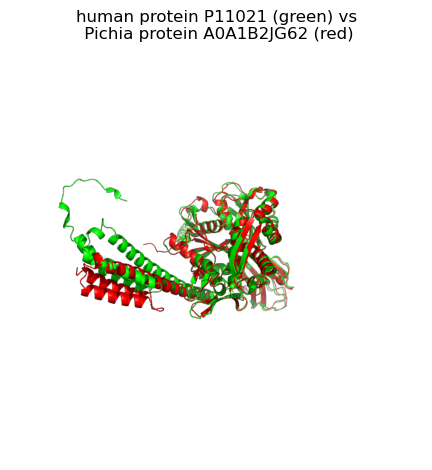

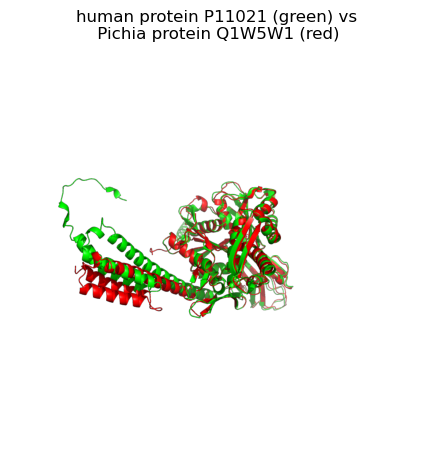

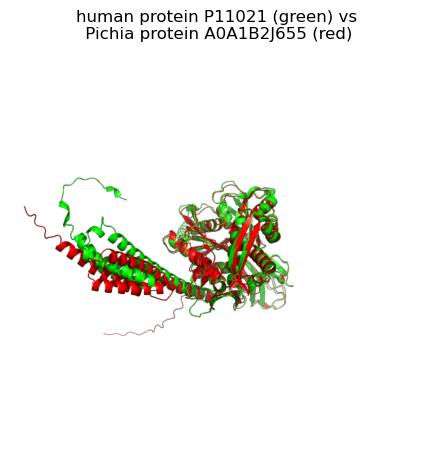

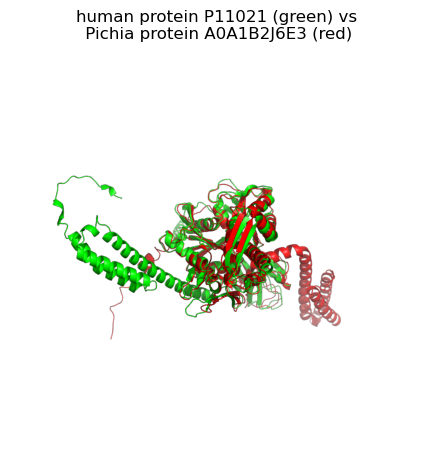

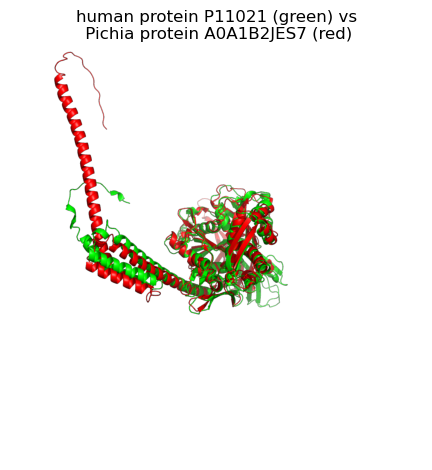

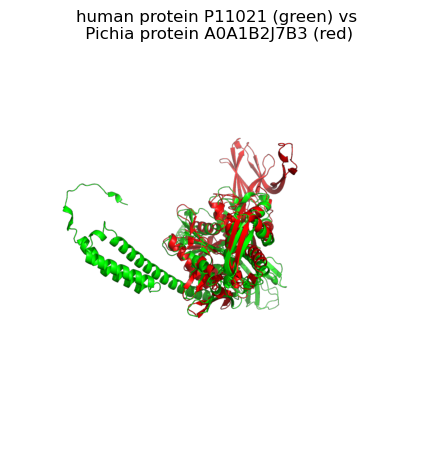

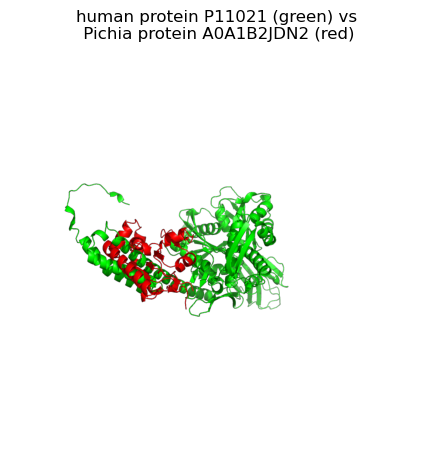

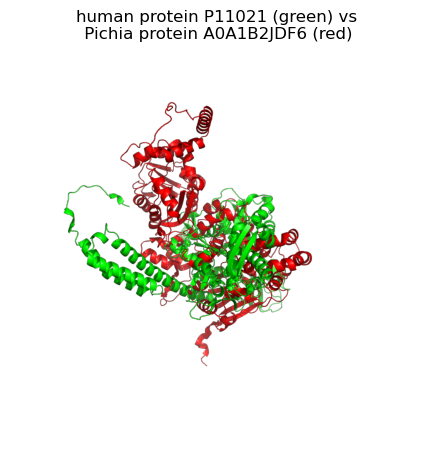

In [ ]:
def png_save(path, title="image"):
    """Save the current PyMOL view as a PNG image."""
    print(f"Image saved to {path}")
    
    cmd.ray(width=1000, height=1000)
    cmd.png(path)

    img = mpimg.imread(path)
    plt.imshow(img)    
    plt.title(title)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(path)
    plt.show()


for i, row in enumerate(pichia_proteins):
    pichia_prot = row['UniProt_ID']
    print(pichia_prot)
    cmd.do(f"fetchAF2 {pichia_prot}")
    cmd.color("red", pichia_prot)
    cmd.align(pichia_prot, human_prot)
    cmd.zoom()
    

    path = f'images/{pichia_prot}_vs_{human_prot}.png'
    title= f"human protein {human_prot} (green) vs\n Pichia protein {pichia_prot} (red)"
    
    png_save(path, title)
    cmd.do(f"hide everything, {pichia_prot}")

for i, pichia_prot in enumerate(pichia_proteins):
    cmd.do(f"show_as cartoon, {pichia_prot}")

Fetch the identified proteins.